In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from src.algonauts.data_processors.image_transforms import transform_alexnet
from src.algonauts.models.alexnet import create_alexnet_softmax

## Train AlexNet Tensorflow Implementation on Imagenette

Here we train our own AlexNet implementation on Imagenette dataset, which is a scaled-down version of the large ImageNet dataset

In [ ]:
experiment_name = 'train_alexnet_imagenette'

In [ ]:
# Load Imagenette dataset
base_dir = '../..'
dataset, info = tfds.load('imagenette/320px', with_info=True, data_dir=f'f{base_dir}/data/tensorflow_datasets')

In [4]:
num_classes=10  # Imagenette has 10 classes

# Get and preprocess training and validation datasets
def preprocess_imagenette(ds, batch_size):
    return ds.shuffle(10000)\
        .map(lambda x: (transform_alexnet(x['image']), tf.one_hot(x['label'], depth=num_classes)))\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

batch_size = 32
train_ds = preprocess_imagenette(dataset['train'], batch_size)
val_ds = preprocess_imagenette(dataset['validation'], batch_size)

In [6]:
# Create AlexNet model
model = create_alexnet_softmax(num_classes)

In [7]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

## Define callbacks

Here we use the following callbacks:
- Early stopping to stop after 3 epochs if loss does not improve more than 0.001
- Checkpoint to save the model every epoch if accuracy has improved
- Tensorboard callback to write logs, which can be loaded later for comparison

In [13]:
import datetime

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'{base_dir}/data/models/checkpoints/{experiment_name}.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"../data/out/training_logs/{experiment_name}/{current_time}")

callbacks = [early_stopping, tensorboard_callback, checkpoint]

## Train, save and plot loss/accuracy on the training and validation set

Epoch 1/10
403/403 [==============================] - ETA: 0s - loss: 1.9782 - accuracy: 0.3600

2023-03-29 02:31:27.775436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


403/403 [==============================] - 128s 301ms/step - loss: 1.9782 - accuracy: 0.3600 - val_loss: 1.7923 - val_accuracy: 0.3700
Epoch 2/10
403/403 [==============================] - 116s 275ms/step - loss: 1.7275 - accuracy: 0.4411 - val_loss: 1.5001 - val_accuracy: 0.5020
Epoch 3/10
403/403 [==============================] - 123s 286ms/step - loss: 1.5281 - accuracy: 0.5176 - val_loss: 1.3090 - val_accuracy: 0.6100
Epoch 4/10
403/403 [==============================] - 127s 281ms/step - loss: 1.4086 - accuracy: 0.5649 - val_loss: 1.5690 - val_accuracy: 0.5200
Epoch 5/10
403/403 [==============================] - 115s 272ms/step - loss: 1.2686 - accuracy: 0.6090 - val_loss: 1.0726 - val_accuracy: 0.6700
Epoch 6/10
403/403 [==============================] - 111s 262ms/step - loss: 1.1649 - accuracy: 0.6452 - val_loss: 1.1105 - val_accuracy: 0.6520
Epoch 7/10
403/403 [==============================] - 113s 268ms/step - loss: 1.1104 - accuracy: 0.6623 - val_loss: 1.0923 - val_accura

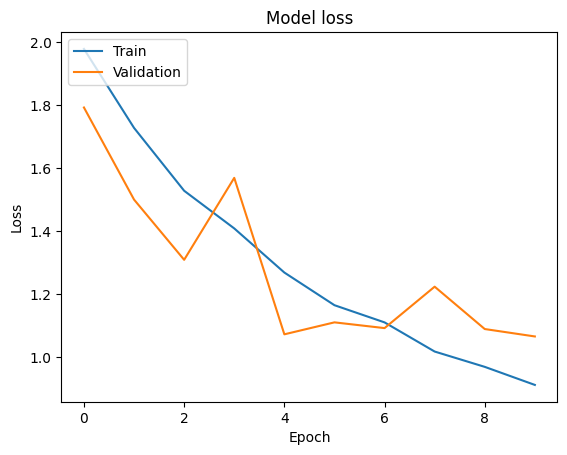

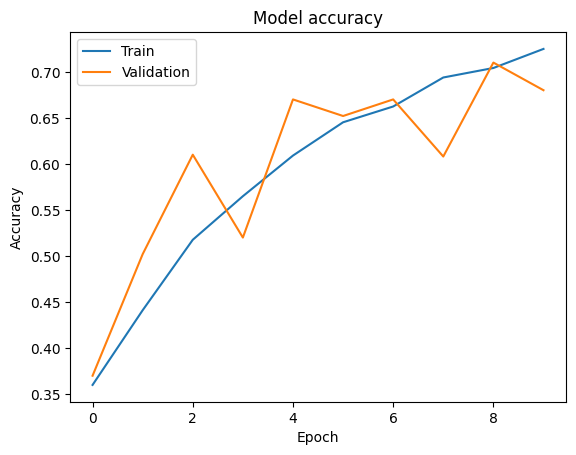

In [15]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)
model.save(f'{base_dir}/models/{experiment_name}.h5')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Train more, up to 25 epochs

Epoch 11/25
403/403 [==============================] - ETA: 0s - loss: 0.8470 - accuracy: 0.7461
Epoch 11: val_accuracy improved from -inf to 0.72400, saving model to ../data/out/checkpoints/alexnet_imagenette/11.h5
403/403 [==============================] - 72s 158ms/step - loss: 0.8470 - accuracy: 0.7461 - val_loss: 0.8898 - val_accuracy: 0.7240
Epoch 12/25
403/403 [==============================] - ETA: 0s - loss: 0.7831 - accuracy: 0.7665
Epoch 12: val_accuracy did not improve from 0.72400
403/403 [==============================] - 68s 156ms/step - loss: 0.7831 - accuracy: 0.7665 - val_loss: 1.2911 - val_accuracy: 0.5940
Epoch 13/25
403/403 [==============================] - ETA: 0s - loss: 0.7375 - accuracy: 0.7733
Epoch 13: val_accuracy improved from 0.72400 to 0.75000, saving model to ../data/out/checkpoints/alexnet_imagenette/13.h5
403/403 [==============================] - 67s 155ms/step - loss: 0.7375 - accuracy: 0.7733 - val_loss: 0.8355 - val_accuracy: 0.7500
Epoch 14/25
40

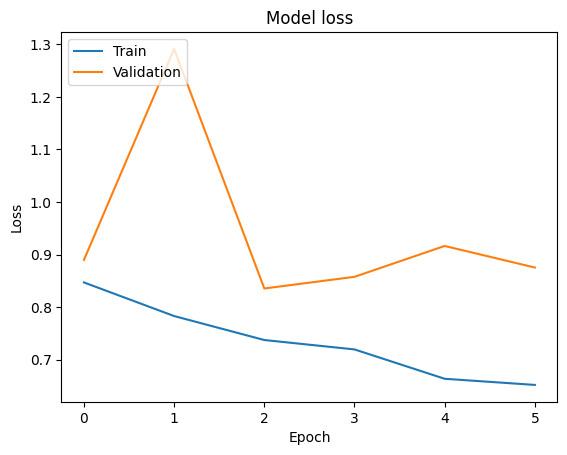

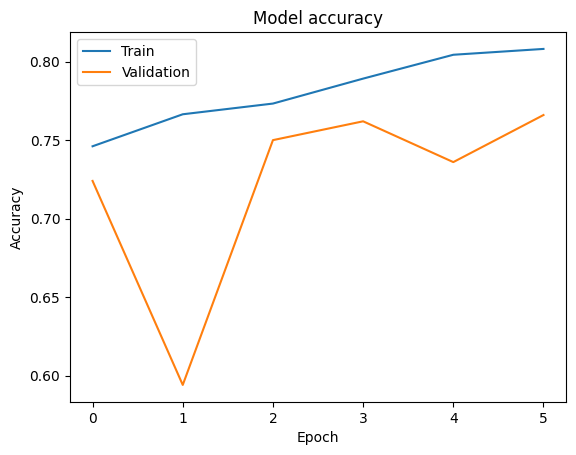

In [16]:
history = model.fit(train_ds, initial_epoch=10, epochs=25, validation_data=val_ds, callbacks=callbacks)
model.save(f'{base_dir}/models/alexnet_imagenette2.h5')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()